In [1]:
#import modules
import numpy as np
import csv
from scipy import special
import matplotlib.pyplot as plt

In [2]:
#helper function to read file
def readFile(fileName):
    with open(fileName) as f:
        reader = csv.reader(f, delimiter="\t")
        d = list(reader)
    return d


In [3]:
# This function evaluates a normalized sum of N Gaussian functions with
# means specified by the input vector mu and standard deviation equal to s
# The function is computed in each point of the input vector x.
#Nota que el vector x que le metes abarca el rango de todas las gaussian y se van sumando los valores
def sumGaussian(x, mu, s):
    N = len(mu)
    G = 0
    for i in range(N):
        G = G + np.exp((-(x-mu[i])**2)/((2*(s**2))))/(np.sqrt(2*np.pi*(s**2)))
    G = G/N #Normalization
    
    return G
        

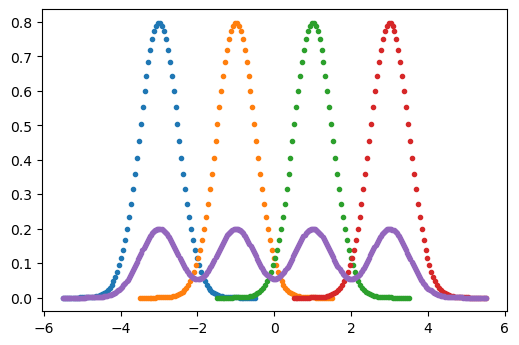

In [29]:
# This block is only to show how sumGaussian works in a graphic way

mu = np.array([-3, -1, 1, 3]) #Vector of means of individual gaussian distribution
s = .5 # Standard Deviation of all gaussian distributions [Try with different values!!]

N = len(mu)

plot0 = plt.figure(0,figsize=(6,4), dpi=100)
for i in range(N):
    #Support of i-th Gaussian distribution (mean plus/minus 5 standard deviations [solo para que se vea bien])
    x = np.linspace(mu[i]-5*s,mu[i]+5*s,100)
    y = np.exp(-((x-mu[i])**2)/(2*s**2))/np.sqrt(2*np.pi*(s**2)) #Computing gaussian
    plt.plot(x,y,".")

# Support of sum of Gaussians defines as interval between lowest mean minus
# 5 std. deviations and highest mean plus 5 std. deviations
x = np.linspace(min(mu)-5*s,max(mu)+5*s,400)
y = sumGaussian(x,mu,s); # Calling function to compute sum of Gaussians in all values of x

plt.plot(x,y,".")



In [5]:
file = readFile("cryptocurrency_prices.txt")
data = file
b = data[0]

# Log-returns

r = np.zeros((len(b)-1,1))
for i in range(len(b)-1):
    den = float(b[i])
    num = float(b[i+1])
    r[i] = np.log(num/den)
    
#Separating the data into training / validation / testing sets (one third of the data each)
pt = 0.33 #Fraction of data to use in training set
pv = 0.33 #Fraction of data to use in validation set

# Indexes at 33% and 66% of the data
index33= int(np.round(pt*len(r)))
index66 = int(np.round((pt+pv)*len(r)))

train_set = r[:index33] # [Training set ] first 33% of the data of r
N_T = len(train_set)

val_set = r[index33:index66] # [Validation set ] second 33% of the data of r

test_set = r[index66:] # [Test set ] third 33% of the data of r

In [6]:
# Maximum likelihood analysis

# Vector of different standard deviations from 1^(-3) to 1^(-1) in log scales with 100 values
h = np.logspace(-3,-1,100) 
L = np.zeros((len(h),1))

#Literal itera con todos los diferentes values de S.D para saber Mac Likelihood
#En otras ocaciones usabamos funciones de maximizacion y no era tan facil porque habia que maximizar
# multiples variables
for i in range(len(h)):
    #Computing log-likelihood for Gaussian kernel evaluated on the
    #validation set (using the training set as fixed parameters)
    
    #QUEEEEEEEEEEEEEEEE PORQUE USA VAL_TRAIN COMO X????????????
    p = sumGaussian(val_set,train_set,h[i]) #Vector of Gaussian kernel values calculated in each point of validation set
    aux = np.sum(np.log(p)) #Computing likelihood
    
    L[i] = aux
h_opt = h[np.where(L == max(L))[0]] #agarra el valor de h en el indice donde esta el max L
print("optimal kernel standard deviation = ", h_opt)

optimal kernel standard deviation =  [0.0070548]


(array([ 0.10423165,  0.        ,  0.2084633 ,  0.        ,  0.10423165,
         0.4169266 ,  0.31269495,  0.4169266 ,  0.93808485,  0.52115825,
         1.77193805,  5.10735085, 24.07751116, 18.3447704 ,  5.10735085,
         3.5438761 ,  1.35501145,  0.4169266 ,  0.31269495,  0.72962155]),
 array([-0.20064485, -0.18496836, -0.16929186, -0.15361537, -0.13793887,
        -0.12226238, -0.10658588, -0.09090939, -0.07523289, -0.0595564 ,
        -0.04387991, -0.02820341, -0.01252692,  0.00314958,  0.01882607,
         0.03450257,  0.05017906,  0.06585556,  0.08153205,  0.09720855,
         0.11288504]),
 <a list of 20 Patch objects>)

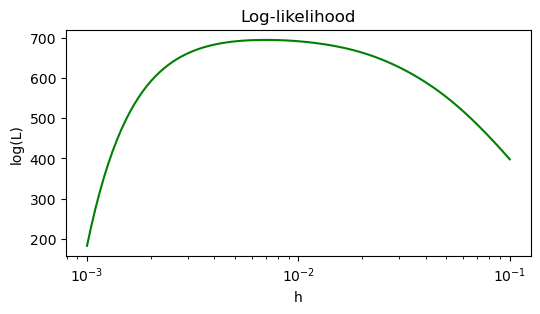

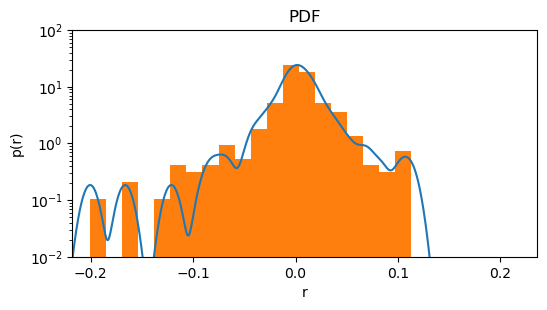

In [28]:
plot1 = plt.figure(1,figsize=(6,3), dpi=100)
#We notice that the h(S.D) that maximizes the log likelihood is in the order of 10^-2.. our optimal h is .007 as you see above
plt.title('Log-likelihood')
plt.plot(h,L,'g')
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('log(L)')

plot2 = plt.figure(2,figsize=(6,3), dpi=100)
plt.title('PDF')
x = np.linspace(min(r)*1.05,max(r)*1.05,1000)
y = sumGaussian(x, train_set, h_opt) #values of kernel density for optimal bandwidth(S.D)
plt.plot(x,y)
plt.yscale('log')
plt.xlim([min(x),max(x)]) #Si no restringes limites no se ve bien
plt.ylim([1e-2,100])
plt.xlabel('r')
plt.ylabel('p(r)')
# Combine train set and validation set. Notice that we are just plotting the histogram, not reating it as always
train_val = np.concatenate((train_set,val_set), axis=0);
plt.hist(train_val,bins =20,density=True,stacked=True) #Ploting histogram



Text(0, 0.5, 'C(r)')

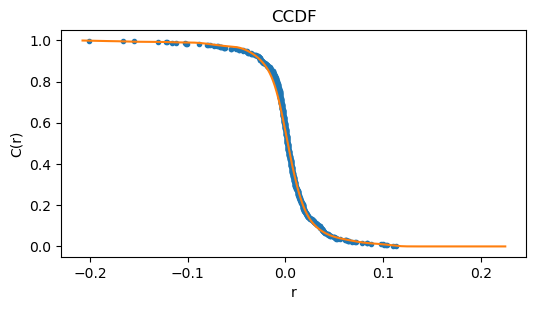

In [37]:
#CCDF Recuerda que falta entender un poco como lo hicimos en y

aux = np.sort(train_val,axis=None); # Returns sorted in ascending order
y = np.arange(1,len(train_val)+1,1)
y = 1 - y/(len(train_val)+1); # Calculating CCDF as rank-frequency plot

x = np.linspace(min(r),max(r),500)
C = np.zeros((500,1))

for i in range(len(x)):
    C[i] = np.sum(1-special.erf((x[i]-train_set)/np.sqrt(2*h_opt**2)))/(2*N_T)

plot2 = plt.figure(2,figsize=(6,3), dpi=100)
plt.title('CCDF')
plt.plot(aux,y,".")
plt.plot(x,C)
plt.xlabel('r')
plt.ylabel('C(r)')